<a href="https://colab.research.google.com/github/gabrielxcosta/Simulation-of-epidemiological-models-in-temporal-mobility-networks/blob/main/gold/explore_the_host_movement_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import bs4
import requests
import math as m
import numpy as np
import pandas as pd
import pickle as pk
import seaborn as sns
import networkx as nx
import geopandas as gpd
import matplotlib as mpl
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap

# Generate travel rates - Auxiliary functions

In [6]:
def generate_temporal_mobility_tensors(nodes, populations, rate_of_movers, basis_net, num_days):
    num_nodes = len(nodes)

    inflow = np.zeros((num_days, num_nodes, num_nodes))
    outflow = np.zeros((num_days, num_nodes, num_nodes))

    # Ordenar nós por população, do menor para o maior
    populations_sorted_indices = np.argsort(populations)

    for day in range(num_days):
        for idx in populations_sorted_indices:
            total_population = populations[idx]
            for i in range(num_nodes):
                for j in range(num_nodes):
                    if basis_net[i, j] == 1:
                        inflow[day, i, j] = rate_of_movers * populations[i] / total_population
                        outflow[day, i, j] = rate_of_movers * populations[j] / total_population

        # Normalizar inflow pelas colunas para que a soma seja igual ao rate_of_movers
        for j in range(num_nodes):
            col_sum = inflow[day, :, j].sum()
            if col_sum > 0:
                inflow[day, :, j] *= rate_of_movers / col_sum

        # Normalizar outflow pelas linhas para que a soma seja igual ao rate_of_movers
        for i in range(num_nodes):
            row_sum = outflow[day, i, :].sum()
            if row_sum > 0:
                outflow[day, i, :] *= rate_of_movers / row_sum

    # Verificação das capacidades e das somas
    for day in range(num_days):
        inflow_sum = inflow[day].sum(axis=0)
        outflow_sum = outflow[day].sum(axis=1)

        print(f"Dia {day + 1}:")
        print("Inflow total por nó (colunas):", inflow_sum)
        print("Outflow total por nó (linhas):", outflow_sum)
        print("Diferença total inflow - outflow por nó:", inflow_sum - outflow_sum)
        print("Taxas de envio por nó:", np.diag(outflow[day]))
        print()

        if np.allclose(inflow_sum, outflow_sum):
            print("Tudo que entra é igual ao que sai para todos os nós.")
        else:
            print("Há discrepâncias entre o que entra e o que sai para alguns nós.")

        if np.allclose(inflow_sum, rate_of_movers) and np.allclose(outflow_sum, rate_of_movers):
            print("As somas de inflow e outflow estão de acordo com a taxa de movimentação.")
        else:
            print("As somas de inflow e outflow não estão de acordo com a taxa de movimentação.")

    return inflow, outflow

# BH networks

## Scraping from updated census of Belo Horizonte - IBGE 2022

In [7]:
# Fazendo a requisição para a página
url = "https://pt.wikipedia.org/wiki/Regi%C3%A3o_Metropolitana_de_Belo_Horizonte"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Encontrando a seção desejada
secao = soup.find('span', id='Colar_Metropolitano')
tabela = secao.find_next('table', class_='toccolours')

# Encontrando todas as linhas da tabela, excluindo as primeiras e as últimas
linhas = tabela.find_all('tr')[3:-7]

# Lista para armazenar os dados
dados = []

# Iterando sobre as linhas da tabela e extraindo os dados
for i, linha in enumerate(linhas):
    colunas = linha.find_all('td')
    if len(colunas) >= 4:
      municipio_1 = colunas[1].text.strip()
      populacao_1 = colunas[2].text.strip()
      area_1 = colunas[3].text.strip()
      pib_1 = colunas[4].text.strip()
      dados.append([municipio_1, populacao_1, area_1, pib_1])

    # Verificando se o índice da linha é maior ou igual a 16
    if i >= 16:
        # Verificar se há um segundo município na mesma linha
        if len(colunas) > 5:
            municipio_2 = colunas[7].text.strip()
            populacao_2 = colunas[8].text.strip()
            area_2 = colunas[9].text.strip()
            pib_2 = colunas[10].text.strip()
            dados.append([municipio_2, populacao_2, area_2, pib_2])

# Criando o DataFrame
BH_census = pd.DataFrame(dados, columns=['munic_nome', 'populacao', 'area_km2', 'PIB'])

BH_census['populacao'] = BH_census['populacao'].apply(lambda x: float(x.replace('.', '').replace(',', '.')))
BH_census['area_km2'] = BH_census['area_km2'].apply(lambda x: float(x.replace('.', '').replace(',', '.')))
BH_census['PIB'] = BH_census['PIB'].apply(lambda x: float(x.replace('.', '').replace(',', '.')) * 1_000_000)
BH_census = BH_census.sort_values(by='munic_nome')

# Verificando se o nome do município contém um asterisco ('*') no final
mask = BH_census['munic_nome'].str.contains('\*$')

# Removendo as linhas que correspondem à condição
BH_census = BH_census[~mask]
BH_census.reset_index(drop=True, inplace=True)
BH_census['munic_nome'] = BH_census['munic_nome'].apply(lambda x: x.upper())

# Exibindo as primeiras linhas do DataFrame
BH_census

,munic_nome,populacao,area_km2,PIB
0,BALDIM,7492.0,556.3,2.013000e+08
1,BELO HORIZONTE,2315560.0,331.4,1.058297e+11
2,BETIM,411846.0,344.1,3.313290e+10
3,BRUMADINHO,38915.0,639.4,4.624900e+09
4,CAETÉ,38776.0,542.5,1.074900e+09
5,CAPIM BRANCO,10663.0,95.3,1.234000e+08
6,CONFINS,7350.0,42.4,4.857000e+08
7,CONTAGEM,621863.0,194.7,3.647980e+10
8,ESMERALDAS,85598.0,909.7,9.731000e+08
9,FLORESTAL,8045.0,194.2,1.428000e+08


## Building the geodataframe

In [8]:
# Carregar o shapefile em um GeoDataFrame
gdf = gpd.read_file('/content/drive/MyDrive/data_IC/BH_data/RMBH_raw_data/Mun_RMBH.shp')
gdf = gdf.sort_values(by='NM_MUNICIP').reset_index(drop=True)
gdf['POPULATION'] = BH_census['populacao']
gdf['AREA'] = BH_census['area_km2']
gdf['GDP'] = BH_census['PIB']
gdf['centroid'] = gdf['geometry'].centroid

gdf

,ID,CD_GEOCODM,NM_MUNICIP,geometry,POPULATION,AREA,GDP,centroid
0,669,3105004,BALDIM,"POLYGON ((606757.520 7864576.779, 606782.510 7...",7492.0,556.3,2.013000e+08,POINT (619447.274 7869692.260)
1,680,3106200,BELO HORIZONTE,"POLYGON ((609816.792 7812766.395, 609786.576 7...",2315560.0,331.4,1.058297e+11,POINT (608874.430 7798947.450)
2,686,3106705,BETIM,"POLYGON ((578133.447 7801230.683, 578147.612 7...",411846.0,344.1,3.313290e+10,POINT (583790.328 7794110.180)
3,711,3109006,BRUMADINHO,"POLYGON ((601241.992 7781499.210, 601266.292 7...",38915.0,639.4,4.624900e+09,POINT (591671.749 7768597.367)
4,723,3110004,CAETÉ,"POLYGON ((640867.584 7817516.413, 640878.857 7...",38776.0,542.5,1.074900e+09,POINT (642720.270 7802579.048)
5,750,3112505,CAPIM BRANCO,"POLYGON ((587152.423 7832294.163, 587151.787 7...",10663.0,95.3,1.234000e+08,POINT (587299.670 7835882.001)
6,811,3117876,CONFINS,"POLYGON ((605962.862 7830572.037, 605963.392 7...",7350.0,42.4,4.857000e+08,POINT (607469.212 7827797.264)
7,819,3118601,CONTAGEM,"POLYGON ((589888.122 7809221.958, 589901.811 7...",621863.0,194.7,3.647980e+10,POINT (595896.169 7800723.832)
8,884,3124104,ESMERALDAS,"POLYGON ((562281.939 7828660.841, 562294.404 7...",85598.0,909.7,9.731000e+08,POINT (572564.078 7817919.230)
9,904,3126000,FLORESTAL,"POLYGON ((553862.507 7806347.455, 553866.057 7...",8045.0,194.2,1.428000e+08,POINT (558329.606 7803052.590)


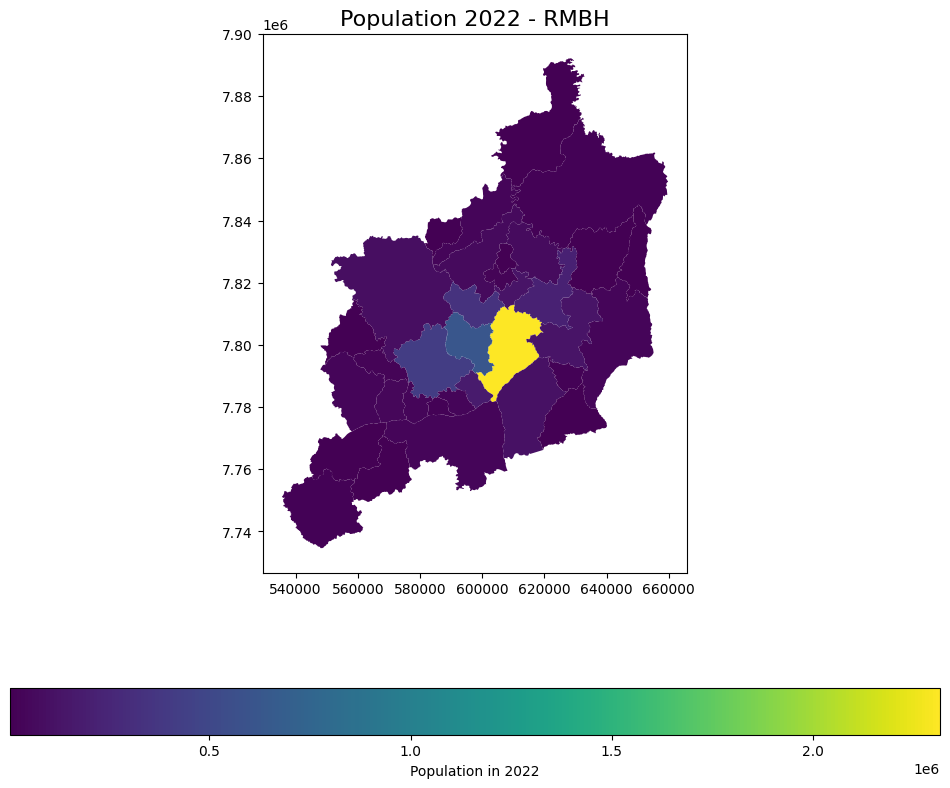

In [9]:
gdf.plot(
    figsize=(12, 10),
    column='POPULATION',
    legend=True,
    cmap='viridis',
    legend_kwds={"label": "Population in 2022", "orientation": "horizontal"},
)

plt.title('Population 2022 - RMBH', fontsize=16)
plt.show()

In [10]:
gdf.to_excel('/content/drive/MyDrive/data_IC/BH_data/output/RMBH_geodataframe/RMBH_geodataframe.xlsx')

## Building the networks

### Basis network

In [11]:
# Criar o dígrafo
BH_basis_net = nx.DiGraph()

# Adicionar nós com atributos
for idx, row in gdf.iterrows():
    node_id = row['ID']
    node_data = {
        'CD_GEOCODM': row['CD_GEOCODM'],
        'NM_MUNICIP': row['NM_MUNICIP'],
        'POPULATION': row['POPULATION'],
        'AREA': row['AREA'],
        'GDP': row['GDP'],
        'xcoord': row['centroid'].x,
        'ycoord': row['centroid'].y
    }
    BH_basis_net.add_node(node_id, **node_data)

# Adicionar arestas entre municípios vizinhos ou que se cruzam
for index, row in gdf.iterrows():
    node_id = row['ID']
    connected_nodes = []

    # Verificar se é o nó com ID '995' ou '1085' para adicionar conexões
    if node_id == 995:
        connected_nodes.append(1085)
    elif node_id == 1085:
        connected_nodes.append(995)

    # Verificar se o município é vizinho ou se se cruzam
    for other_index, other_row in gdf.iterrows():
        if node_id != other_row['ID'] and row['geometry'].intersects(other_row['geometry']):
            connected_nodes.append(other_row['ID'])

    # Adicionar arestas
    for connected_node in connected_nodes:
        BH_basis_net.add_edge(node_id, connected_node)

nx.write_graphml(BH_basis_net, '/content/drive/MyDrive/data_IC/BH_data/output/RMBH_geodataframe/BH_basis_net.GraphML')

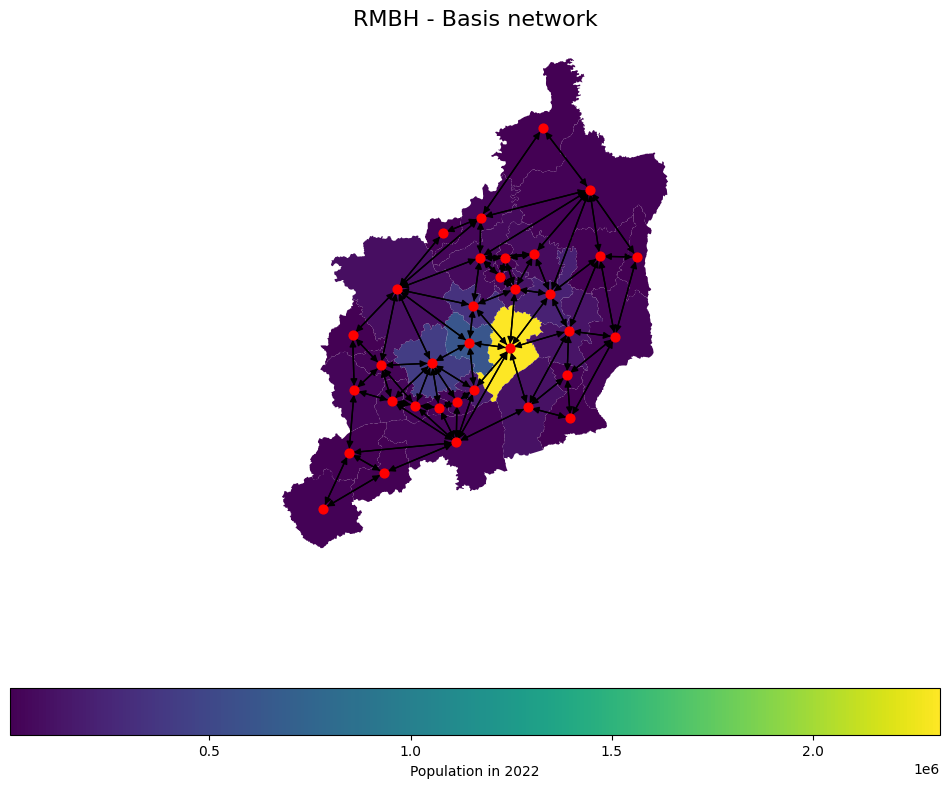

In [12]:
gdf.plot(
    figsize=(12, 10),
    column='POPULATION',
    legend=True,
    cmap='viridis',
    legend_kwds={"label": "Population in 2022", "orientation": "horizontal"},
)

# Plotar o grafo (opcional)
pos = {node: (data['xcoord'], data['ycoord']) for node, data in BH_basis_net.nodes(data=True)}
nx.draw(BH_basis_net, pos, node_size=40, node_color='red', edge_color='black')
plt.title('RMBH - Basis network', fontsize=16)
plt.savefig('/content/drive/MyDrive/data_IC/BH_data/output/RMBH_geodataframe/RMBH_basis.network.pdf')
plt.show()

### Generate the temporal weighted mobility matrices

* $\large w_{ij}^{in}$
* $\large w_{ij}^{out}$


In [13]:
per_movers = .05  # Percentage of individuals that move between nodes

# Get the names
names = []
for _, v in nx.get_node_attributes(BH_basis_net, 'NM_MUNICIP').items():
    parts = v.split()
    capitalized_parts = [parts[0].capitalize()] + [part.lower() if part.lower() in ['de', 'da', 'das'] else part.capitalize() for part in parts[1:]]
    capitalized_name = ' '.join(capitalized_parts)
    names.append(capitalized_name)

# Gerar a matriz de adjacência a partir do grafo
basis_net = nx.to_numpy_array(BH_basis_net)

# Obter os nós e as populações
nodes = [i for i in range(len(BH_basis_net.nodes()))]
populations = [v for _, v in nx.get_node_attributes(BH_basis_net, 'POPULATION').items()]

# Gerar as matrizes temporais de mobilidade ponderada
inflow, outflow = generate_temporal_mobility_tensors(nodes, populations, per_movers, basis_net, 45)

Dia 1:
Inflow total por nó (colunas): [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
Outflow total por nó (linhas): [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
Diferença total inflow - outflow por nó: [ 0.0000000e+00  6.9388939e-18  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00 -6.9388939e-18
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  6.9388939e-18  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  6.9388939e-18  6.9388939e-18
  0.0000000e+00  0.0000000e+00  6.9388939e-18  0.0000000e+00
  0.0000000e+00  6.9388939e-18]
Taxas de envio por nó:

### Generate the temporal network visualization

# Transport operator





**Definition:**
Corresponds to the **net balance** of the
individuals of state $X$ travelling $in$ and $out$ of city i. This last term,
the transport operator $\Omega_i$, depends on the probability
$p_{ij}$ that an individual of state $X$ will go from city $i$ to
city $j$, and can be simply written as:

$$\large \Omega_{i} (\{X \}) = \sum_{j}^{K} p_{ji} \{X_j\} - p_{ij} \{X_i\}$$

In this context, $p_{ji}$ is a tensor of order 3, where the first index represents time (**implicit**), and the next two indices correspond to the number of nodes. Specifically, this tensor has dimensions of 60 days, 303 nodes, and 303 nodes for the.

**Our definition:**
$$\large \Omega_{i} (\{X \}) = \sum_{j}^{K} w_{ji}^{in} \{X_j\} - w_{ij}^{out} \{X_i\}$$

* $\sum_{j} w_{ji}^{in} \{X_j\} \rightarrow$ ingoing;
* $\sum_{j} w_{ij}^{out} \{X_i\} \rightarrow$ outgoing.

**Our definition:**
$$\large \Omega_{i} (\{X \}) = \sum_{j}^{K} w_{ji}^{in} \{X_j\} - w_{ij}^{out} \{X_i\}$$

* $\sum_{j} w_{ji}^{in} \{X_j\} \rightarrow$ ingoing;
* $\sum_{j} w_{ij}^{out} \{X_i\} \rightarrow$ outgoing.

# Host movement models

Metapopulation models to represent a network of geographically isolated populations of hosts. Each population occupies a location where local conditions may affect transmission intensity. Each population $i$ contains $N_i$ hosts. We assume that the population at each location remains stable over time—in applied contexts each population may be calibrated using census or other population data. Disease transmission is assumed to be completely local, such that hosts from different subpopulations come into contact with one another only if they travel to occupy the same location. We describe and compare two simple models of host movement, each of which represents a different set of rules governing how hosts move from one location to another.

The Flux model is a Eulerian movement model which describes hosts as diffusing from one subpopulation to another:

$$\large \dot{N_{i}} = \Omega_i (\{N \})$$

or

$$\large \dot{N_{i}} = \sum_{j}^{K} w_{ji}^{in} \{N_j\} - w_{ij}^{out} \{N_i\}$$

where $N_i$ counts the number of hosts currently located at site $i$. The total number of hosts remains constant over time $N = \sum_{i=1}^{K} N_i$.

In [14]:
sns.set_style('darkgrid')

In [15]:
class FluxModel:
    def __init__(self, N, inflow_matrices, outflow_matrices):
        """
        Inicializa o modelo de fluxo.

        Parâmetros:
        N : array_like
            Vetor inicial de populações em cada nó.
        inflow_matrices : list of numpy.ndarray
            Lista de matrizes NxN das taxas de entrada para cada dia.
        outflow_matrices : list of numpy.ndarray
            Lista de matrizes NxN das taxas de saída para cada dia.
        """
        self.N = N
        self.inflow_matrices = inflow_matrices
        self.outflow_matrices = outflow_matrices
        self.days = len(inflow_matrices)
        self.last_day = float(self.days)

    def omega(self, t, N):
        """
        Calcula a taxa de mudança de hospedeiros nas subpopulações baseada nas matrizes de fluxo.

        Parâmetros:
        t : float
            Tempo atual (em dias).
        N : array_like
            Vetor atual de populações em cada nó.

        Retorna:
        dNdt : array_like
            Taxa de mudança de N.
        """
        day = m.floor(t)  # Ajuste para arredondar o tempo para o dia mais próximo
        if t == self.last_day:
            day = int(self.last_day - 1.)
        print('CURRENT TIME POINT: ', t, '- CALCULATED DAY: ', day)  # Debug para verificar o tempo e o dia calculado
        inflow_matrix = self.inflow_matrices[day]
        outflow_matrix = self.outflow_matrices[day]

        dN_dt = np.zeros_like(N)

        for i in range(len(N)):
            incoming = np.sum(inflow_matrix[i, :] * N)
            outgoing = np.sum(outflow_matrix[:, i] * N[i])
            dN_dt[i] = incoming - outgoing

        return dN_dt

    def solve(self, t_span, N0, num_points=25000, method='RK45'):
        """
        Resolve o sistema de equações diferenciais com um número fixo de pontos de integração.

        Parâmetros:
        t_span : tuple
            Intervalo de tempo para a integração (t0, tf).
        N0 : array_like
            Vetor inicial de populações em cada nó.
        num_points : int, optional
            Número de pontos de integração ao longo do intervalo de tempo (padrão é 25000).
        method : str, optional
            Método de integração a ser usado por solve_ivp (padrão é 'RK45').

        Retorna:
        result : OdeResult
            Objeto com a solução.
        """
        t_eval = np.linspace(t_span[0], t_span[1], num_points)
        sol = solve_ivp(self.omega, t_span, N0, method=method, t_eval=t_eval, dense_output=True)
        return sol

    def check_constraint(self, solution):
        if np.allclose(np.sum(solution.y, axis=0), np.sum(self.N)):
          print('Constraint satisfied!')
        else:
          print('Constraint not satisfied!')

CURRENT TIME POINT:  0.0 - CALCULATED DAY:  0
CURRENT TIME POINT:  1e-06 - CALCULATED DAY:  0
CURRENT TIME POINT:  2e-07 - CALCULATED DAY:  0
CURRENT TIME POINT:  3e-07 - CALCULATED DAY:  0
CURRENT TIME POINT:  8e-07 - CALCULATED DAY:  0
CURRENT TIME POINT:  8.888888888888888e-07 - CALCULATED DAY:  0
CURRENT TIME POINT:  1e-06 - CALCULATED DAY:  0
CURRENT TIME POINT:  1e-06 - CALCULATED DAY:  0
CURRENT TIME POINT:  3e-06 - CALCULATED DAY:  0
CURRENT TIME POINT:  4e-06 - CALCULATED DAY:  0
CURRENT TIME POINT:  9e-06 - CALCULATED DAY:  0
CURRENT TIME POINT:  9.888888888888889e-06 - CALCULATED DAY:  0
CURRENT TIME POINT:  1.1e-05 - CALCULATED DAY:  0
CURRENT TIME POINT:  1.1e-05 - CALCULATED DAY:  0
CURRENT TIME POINT:  3.0999999999999995e-05 - CALCULATED DAY:  0
CURRENT TIME POINT:  4.0999999999999994e-05 - CALCULATED DAY:  0
CURRENT TIME POINT:  9.099999999999999e-05 - CALCULATED DAY:  0
CURRENT TIME POINT:  9.988888888888888e-05 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.0001109999999

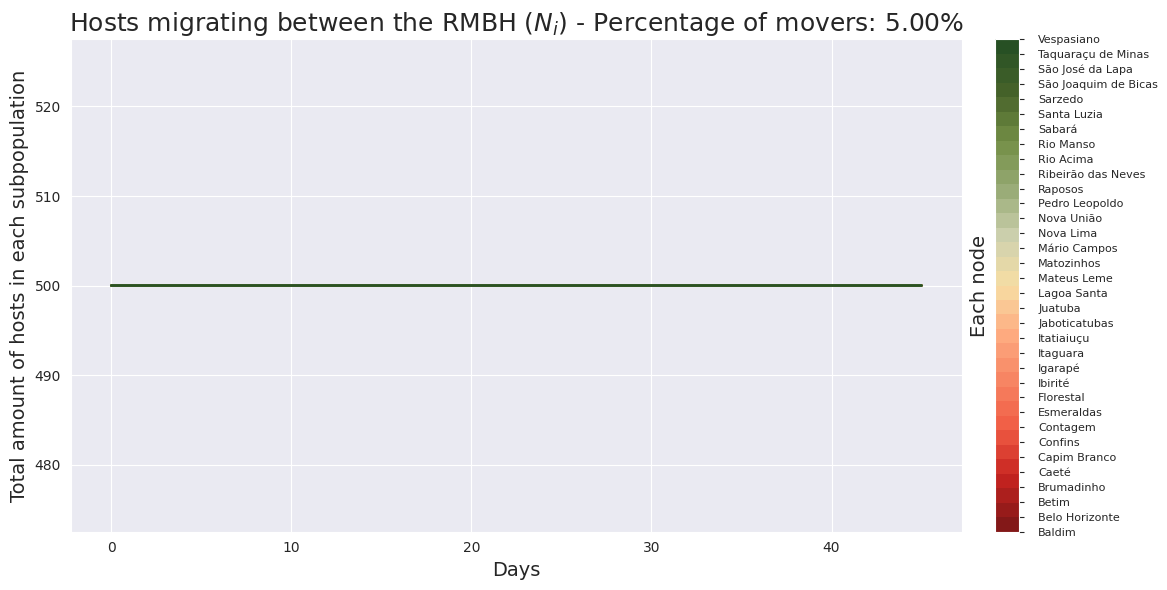

INTEGRATION STEPS:
[0.00100002 0.00100002 0.00100002 ... 0.00100002 0.00100002 0.00100002]


In [43]:
cmap = ['#831818FF', '#C62320FF', '#F05B43FF', '#F78462FF', '#FEAC81FF', '#F7DEA3FF', '#CED1AFFF', '#98AB76FF', '#748F46FF', '#47632AFF', '#275024FF']
cmap = LinearSegmentedColormap.from_list('paquin', cmap[:], N=np.shape(inflow)[1])

#N0 = np.array([500] * (np.shape(inflow)[1] - 1) + [1000])  # População inicial em cada nó
N0 = np.array([500] * np.shape(inflow)[1])  # População inicial em cada nó
#N0 = np.array([v for _, v in nx.get_node_attributes(BH_basis_net, 'POPULATION').items()])
t_span = (0, 45)  # Intervalo de tempo de 45 dias

flux_model = FluxModel(N0, inflow, outflow)
solution = flux_model.solve(t_span, N0, num_points=45000)

t = solution.t
N_t = solution.y

# Criação da figura e do eixo (axes)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

for i in range(np.shape(inflow)[1]):
    ax.plot(t, N_t[i], color=cmap(i), alpha=.75)

ax.set_xlabel('Days', fontsize=14)
ax.set_ylabel('Total amount of hosts in each subpopulation', fontsize=14)
ax.set_title(r'Hosts migrating between the RMBH ($N_{i}$)' + f' - Percentage of movers: {per_movers * 100:.2f}%', fontsize=18)

# Adicionando a barra de cores à direita
norm = mpl.colors.Normalize(vmin=1, vmax=np.shape(inflow)[1])
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
ticks = np.arange(1, np.shape(inflow)[1] + 1, 1)  # Definindo os ticks de 1 a np.shape(inflow)[1]
cbar = plt.colorbar(sm, orientation='vertical', ax=ax, ticks=ticks, pad=0.03)
cbar.set_label('Each node', fontsize=14)
cbar.ax.yaxis.set_label_position('left')  # Posiciona o label à direita
cbar.ax.yaxis.set_ticks_position('right')  # Posiciona os ticks à direita
cbar.ax.yaxis.set_tick_params(pad=10)  # Ajusta o espaço entre os ticks e o label

# Adicionando os nomes dos municípios como legendas no colorbar azul
cbar.ax.set_yticklabels([names[i] for i in range(np.shape(inflow)[1])], fontsize=8)

plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/data_IC/BH_data/output/models_integration/RMBH_flux_model_{per_movers * 100:.2f}%_movers.pdf')
plt.show()

# Verificando os passos de integração
print("INTEGRATION STEPS:")
print(np.diff(solution.t))

In [44]:
flux_model.check_constraint(solution)

Constraint satisfied!


# SIR with host movement between the subpopulations

Incorporating the Eulerian movement model into the ordinary SIR compartmental model yields the following set of $3 K$ equations:

\begin{cases}
    \dot{S_{i}} = -\beta_{i} \frac{S_{i}I_{i}}{N_{i}} -\sum_{j=1}^{K} w_{ij}^{out} S_{i} + \sum_{j=1}^{K} w_{ij}^{in} S_{j} \\
    \dot{I_{i}} = \beta_{i} \frac{S_{i}I_{i}}{N_{i}} - \gamma I_{i} -\sum_{j=1} ^{K} w_{ij}^{out} I_{i} + \sum_{j=1}^{K} w_{ij}^{in} I_{j} \\
    \dot{R_{i}} = \gamma I_{i} -\sum_{j=1}^{K} w_{ij}^{out} R_{i} + \sum_{j=1}^{ K} w_{ij}^{in} R_{j}
\end{cases}

These equations introduce additional terms to the standard SIR model. Specifically, the terms in which $-\sum_{j=1}^{K} w_{ij}^{out} S_{i}$, $-\sum_{j=1} ^{K} w_{ij}^{out} I_{i}$, and $-\sum_{j=1}^{K} w_{ij}^{out} R_{i}$ represent the outflow of susceptible, infected, and recovered individuals from site $i$ to other sites, respectively. Terms with the ``in`` superscript depict inflows.

In [45]:
class SIRFluxModel:
    def __init__(self, S0, I0, R0, inflow_matrices, outflow_matrices, beta, gamma):
        """
        Inicializa o modelo SIR com fluxo.

        Parâmetros:
        S0 : array_like
            Vetor inicial de suscetíveis em cada nó.
        I0 : array_like
            Vetor inicial de infectados em cada nó.
        R0 : array_like
            Vetor inicial de recuperados em cada nó.
        inflow_matrices : list of numpy.ndarray
            Lista de matrizes NxN das taxas de entrada para cada dia.
        outflow_matrices : list of numpy.ndarray
            Lista de matrizes NxN das taxas de saída para cada dia.
        beta : array_like
            Taxa de transmissão em cada nó.
        gamma : float
            Taxa de recuperação (assumida constante para todos os nós).
        """
        self.S0 = S0
        self.I0 = I0
        self.R0 = R0
        self.inflow_matrices = inflow_matrices
        self.outflow_matrices = outflow_matrices
        self.beta = beta
        self.gamma = gamma
        self.N = S0 + I0 + R0
        self.days = len(inflow_matrices)
        self.last_day = float(self.days)

    def sir_flux(self, t, y):
        """
        Equações diferenciais do modelo SIR com fluxo.

        Parâmetros:
        t : float
            Tempo atual (em dias).
        y : array_like
            Vetor atual de [S, I, R] em cada nó.

        Retorna:
        dydt : array_like
            Taxa de mudança de [S, I, R].
        """
        S, I, R = np.split(y, 3)
        day = int(np.floor(t))
        if t == self.last_day:
            day = int(self.last_day - 1)
        print('CURRENT TIME POINT: ', t, '- CALCULATED DAY: ', day)  # Debug para verificar o tempo e o dia calculado
        inflow_matrix = self.inflow_matrices[day]
        outflow_matrix = self.outflow_matrices[day]

        dS_dt = -self.beta * S * I / self.N
        dI_dt = self.beta * S * I / self.N - self.gamma * I
        dR_dt = self.gamma * I

        dS_flux = np.zeros_like(S)
        dI_flux = np.zeros_like(I)
        dR_flux = np.zeros_like(R)

        for i in range(len(S)):
            incoming_S = np.sum(inflow_matrix[i, :] * S)
            outgoing_S = np.sum(outflow_matrix[:, i] * S[i])
            dS_flux[i] = incoming_S - outgoing_S

            incoming_I = np.sum(inflow_matrix[i, :] * I)
            outgoing_I = np.sum(outflow_matrix[:, i] * I[i])
            dI_flux[i] = incoming_I - outgoing_I

            incoming_R = np.sum(inflow_matrix[i, :] * R)
            outgoing_R = np.sum(outflow_matrix[:, i] * R[i])
            dR_flux[i] = incoming_R - outgoing_R

        dS_dt += dS_flux
        dI_dt += dI_flux
        dR_dt += dR_flux

        return np.concatenate([dS_dt, dI_dt, dR_dt])

    def solve(self, t_span, num_points=25000, method='RK45'):
        """
        Resolve o sistema de equações diferenciais com um número fixo de pontos de integração.

        Parâmetros:
        t_span : tuple
            Intervalo de tempo para a integração (t0, tf).
        num_points : int, optional
            Número de pontos de integração ao longo do intervalo de tempo (padrão é 25000).
        method : str, optional
            Método de integração a ser usado por solve_ivp (padrão é 'RK45').

        Retorna:
        result : OdeResult
            Objeto com a solução.
        """
        y0 = np.concatenate([self.S0, self.I0, self.R0])
        t_eval = np.linspace(t_span[0], t_span[1], num_points)
        sol = solve_ivp(self.sir_flux, t_span, y0, method=method, t_eval=t_eval, dense_output=True)
        return sol

    def check_constraint(self, solution):
        """
        Verifica se a população total (N_i = S_i + I_i + R_i) é preservada ao longo do tempo.

        Parâmetros:
        solution : OdeResult
            Objeto com a solução obtida pelo método solve.

        Retorna:
        bool
            True se a condição é satisfeita, False caso contrário.
        """
        S_t = solution.y[:len(self.N), :]
        I_t = solution.y[len(self.N):2*len(self.N), :]
        R_t = solution.y[2*len(self.N):, :]

        N_t = S_t + I_t + R_t

        if np.allclose(np.sum(N_t, axis=0), np.sum(self.N)):
            print('Constraint satisfied!')
        else:
            print('Constraint not satisfied!')

    def plot_heatmap_for_compartment(self, solution, compartment):
        compartments = {'S': solution.y[:len(self.N), :],
                        'I': solution.y[len(self.N):2*len(self.N), :],
                        'R': solution.y[2*len(self.N):, :]}

        if compartment not in compartments:
            raise ValueError("Compartment must be 'S', 'I', or 'R'")

        data = compartments[compartment]
        num_nodes = data.shape[0]
        norms = np.zeros((num_nodes, num_nodes))

        for i in range(num_nodes):
            for j in range(num_nodes):
                diff = data[i, :] - data[j, :]
                norms[i, j] = np.linalg.norm(diff)

        norms_percentage = (norms / norms.max()) * 100

        fig, ax = plt.subplots(figsize=(10, 8))
        cax = ax.matshow(norms_percentage, cmap='viridis')

        ax.set_xticks(np.arange(num_nodes))
        ax.set_yticks(np.arange(num_nodes))

        ax.set_xticklabels(np.arange(num_nodes), fontsize=8)
        ax.set_yticklabels(np.arange(num_nodes), fontsize=8)

        plt.setp(ax.get_xticklabels(), rotation=90, ha="center", rotation_mode="anchor")

        ax.xaxis.set_ticks_position('bottom')
        ax.xaxis.set_tick_params(width=0)
        ax.yaxis.set_tick_params(width=0)

        ax.grid(False)

        plt.title(f'Norm Heatmap for {compartment} Compartment')
        plt.xlabel('Node')
        plt.ylabel('Node')
        fig.colorbar(cax)

        plt.show()

A saída de streaming foi truncada nas últimas 5000 linhas.
dI_flux[i]=1.6459913315819747
dR_flux[i]=0.5484084200090232
dS_flux[i]=1.7611566234133833
dI_flux[i]=-1.4843832364762584
dR_flux[i]=-0.2767733869371254
dS_flux[i]=-5.380608254350655
dI_flux[i]=3.5540440383471434
dR_flux[i]=1.8265642160035132
dS_flux[i]=6.932376466373177
dI_flux[i]=-5.053209614116602
dR_flux[i]=-1.8791668522565637
dS_flux[i]=-0.09829304680142847
dI_flux[i]=0.07491484075976435
dR_flux[i]=0.02337820604166406
dS_flux[i]=3.7808582083391364
dI_flux[i]=-3.0460097743119556
dR_flux[i]=-0.7348484340271821
dS_flux[i]=1.1549145224000243
dI_flux[i]=-0.6759592778392709
dR_flux[i]=-0.47895524456075367
dS_flux[i]=5.60541154383305
dI_flux[i]=-2.827221047971106
dR_flux[i]=-2.7781904958619448
dS_flux[i]=0.9078611587694816
dI_flux[i]=-0.7684377946067655
dR_flux[i]=-0.13942336416271622
dS_flux[i]=-9.957974999920639
dI_flux[i]=6.639962340034782
dR_flux[i]=3.318012659885857
dS_flux[i]=-0.6674030389729326
dI_flux[i]=0.4775136218975214

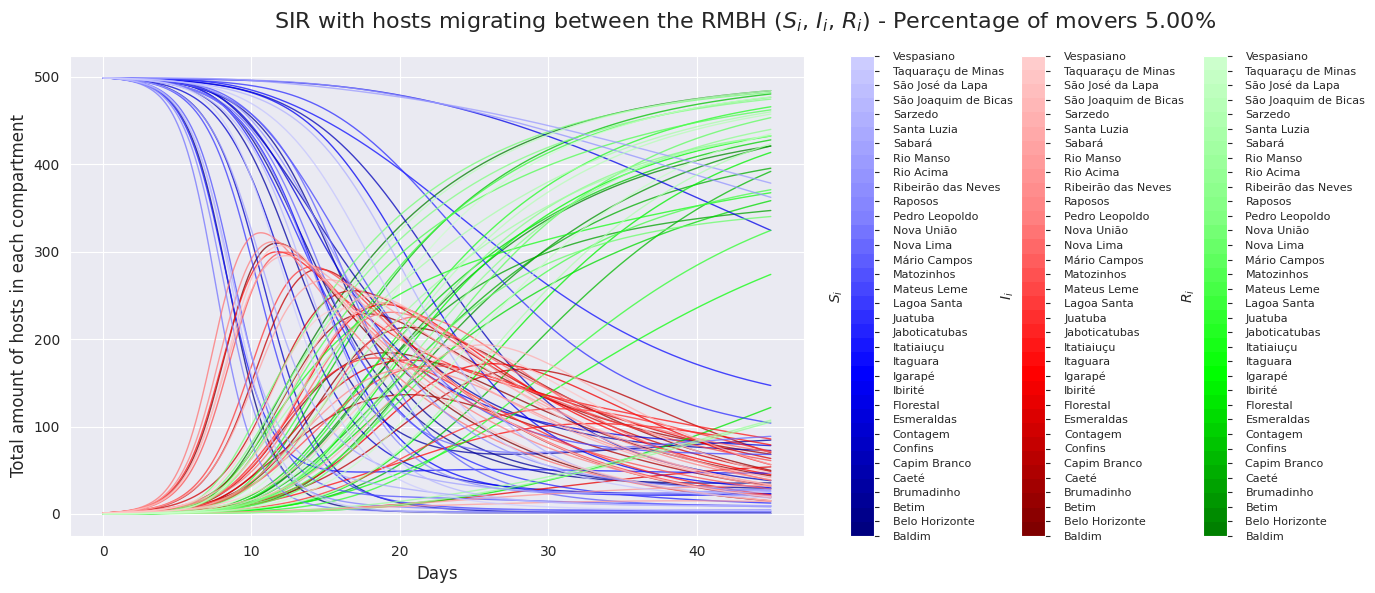

In [49]:
# Definindo os colormaps
blue_colors = [(0, 0, 0.5), (0, 0, 1), (0.5, 0.5, 1), (0.8, 0.8, 1)]  # azul escuro para azul claro
green_colors = [(0, 0.5, 0), (0, 1, 0), (0.5, 1, 0.5), (0.8, 1, 0.8)]  # verde escuro para verde claro
red_colors = [(0.5, 0, 0), (1, 0, 0), (1, 0.5, 0.5), (1, 0.8, 0.8)]  # vermelho escuro para vermelho claro

n_bins = np.shape(inflow)[1]  # número de bins para o colormap

blue_cmap = LinearSegmentedColormap.from_list('dark_to_light_blue', blue_colors, N=n_bins)
green_cmap = LinearSegmentedColormap.from_list('dark_to_light_green', green_colors, N=n_bins)
red_cmap = LinearSegmentedColormap.from_list('dark_to_light_red', red_colors, N=n_bins)

S0 = N0 - 1
I0 = np.array([1] * np.shape(inflow)[1])
R0 = np.array([0] * np.shape(inflow)[1])
#S0 = np.array([499] * np.shape(inflow)[1])  # Vetor inicial de suscetíveis em cada nó
#I0 = np.array([1] * np.shape(inflow)[1])  # Vetor inicial de infectados em cada nó
#R0 = np.array([0] * np.shape(inflow)[1])  # Vetor inicial de recuperados em cada nó
#beta = np.array([0.3] * np.shape(inflow)[1])  # Taxa de transmissão em cada nó
beta = np.random.uniform(0, 0.9, len(nodes))
gamma = 0.1  # Taxa de recuperação (constante para todos os nós)

sir_flux_model = SIRFluxModel(S0, I0, R0, inflow, outflow, beta, gamma)
t_span = (0, 45)  # Intervalo de tempo de 45 dias

solution = sir_flux_model.solve(t_span, num_points=50000)

t = solution.t
S_t, I_t, R_t = np.split(solution.y, 3)

fig, ax = plt.subplots(figsize=(15, 6))  # Reduzindo o tamanho da figura

for i in range(np.shape(inflow)[1]):
    ax.plot(t, S_t[i], color=blue_cmap(i), lw=1, alpha=0.75)
    ax.plot(t, I_t[i], color=red_cmap(i), lw=1, alpha=0.75)
    ax.plot(t, R_t[i], color=green_cmap(i), lw=1, alpha=0.75)

# Adicionando barras de cores menores à direita com labels centralizados
norm = mpl.colors.Normalize(vmin=1, vmax=np.shape(inflow)[1])

sm_green = ScalarMappable(cmap=green_cmap, norm=norm)
sm_green.set_array([])
ticks_green = np.arange(1, n_bins + 1, 1)  # Definindo os ticks de 1 a np.shape(inflow)[1]
cbar_green = plt.colorbar(sm_green, orientation='vertical', ax=ax, ticks=ticks_green, pad=0.01)
cbar_green.set_label(r'$R_{i}$', fontsize=10)
cbar_green.ax.yaxis.set_label_position('left')  # Posiciona o label à direita
cbar_green.ax.yaxis.set_ticks_position('right')  # Posiciona os ticks à direita
cbar_green.ax.yaxis.set_tick_params(pad=10)  # Ajusta o espaço entre os ticks e o label

# Adicionando os nomes dos municípios como legendas no colorbar verde
cbar_green.ax.set_yticklabels([names[i] for i in range(np.shape(inflow)[1])], fontsize=8)

sm_red = ScalarMappable(cmap=red_cmap, norm=norm)
sm_red.set_array([])
ticks_red = np.arange(1, n_bins + 1, 1)  # Definindo os ticks de 1 a np.shape(inflow)[1]
cbar_red = plt.colorbar(sm_red, orientation='vertical', ax=ax, ticks=ticks_red, pad=0.03)
cbar_red.set_label(r'$I_{i}$', fontsize=10)
cbar_red.ax.yaxis.set_label_position('left')  # Posiciona o label à direita
cbar_red.ax.yaxis.set_ticks_position('right')  # Posiciona os ticks à direita
cbar_red.ax.yaxis.set_tick_params(pad=10)  # Ajusta o espaço entre os ticks e o label

# Adicionando os nomes dos municípios como legendas no colorbar vermelho
cbar_red.ax.set_yticklabels([names[i] for i in range(np.shape(inflow)[1])], fontsize=8)

sm_blue = ScalarMappable(cmap=blue_cmap, norm=norm)
sm_blue.set_array([])
ticks_blue = np.arange(1, n_bins + 1, 1)  # Definindo os ticks de 1 a np.shape(inflow)[1]
cbar_blue = plt.colorbar(sm_blue, orientation='vertical', ax=ax, ticks=ticks_blue, pad=0.05)
cbar_blue.set_label(r'$S_{i}$', fontsize=10)
cbar_blue.ax.yaxis.set_label_position('left')  # Posiciona o label à direita
cbar_blue.ax.yaxis.set_ticks_position('right')  # Posiciona os ticks à direita
cbar_blue.ax.yaxis.set_tick_params(pad=10)  # Ajusta o espaço entre os ticks e o label

# Adicionando os nomes dos municípios como legendas no colorbar azul
cbar_blue.ax.set_yticklabels([names[i] for i in range(np.shape(inflow)[1])], fontsize=8)

ax.set_xlabel('Days', fontsize=12)
ax.set_ylabel('Total amount of hosts in each compartment', fontsize=12)
fig.suptitle(r'SIR with hosts migrating between the RMBH ($S_i$, $I_i$, $R_i$)' + f' - Percentage of movers {per_movers * 100:.2f}%', fontsize=16)

# Ajustando a posição da legenda
#ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

plt.subplots_adjust(right=0.5)  # Ajustando o espaço à direita das barras de cores
plt.tight_layout()

# Salvando a figura como PDF otimizado
plt.savefig(f'/content/drive/MyDrive/data_IC/BH_data/output/models_integration/RMBH_SIR_model_{per_movers * 100:.2f}%_movers.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [50]:
sir_flux_model.check_constraint(solution)

Constraint satisfied!


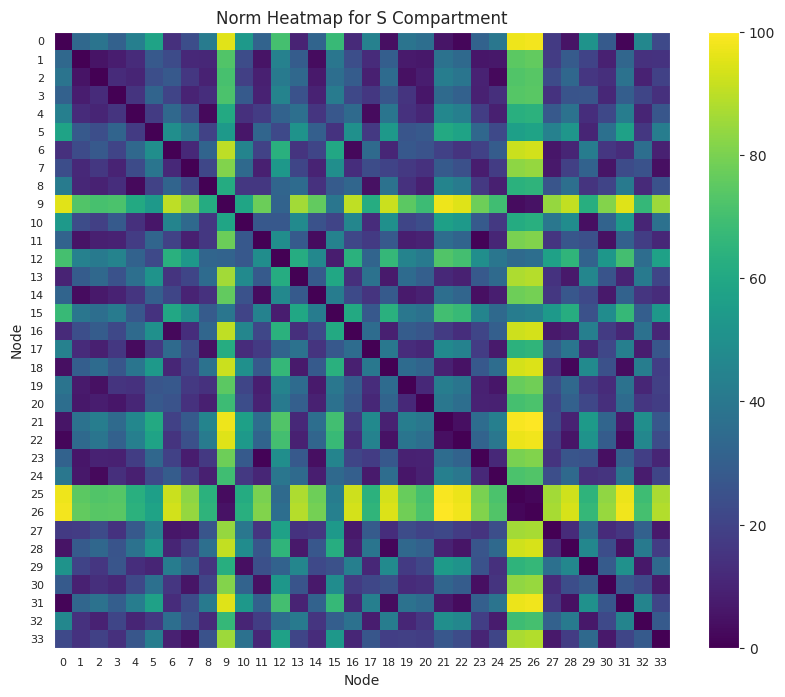

In [51]:
sir_flux_model.plot_heatmap_for_compartment(solution, 'S')

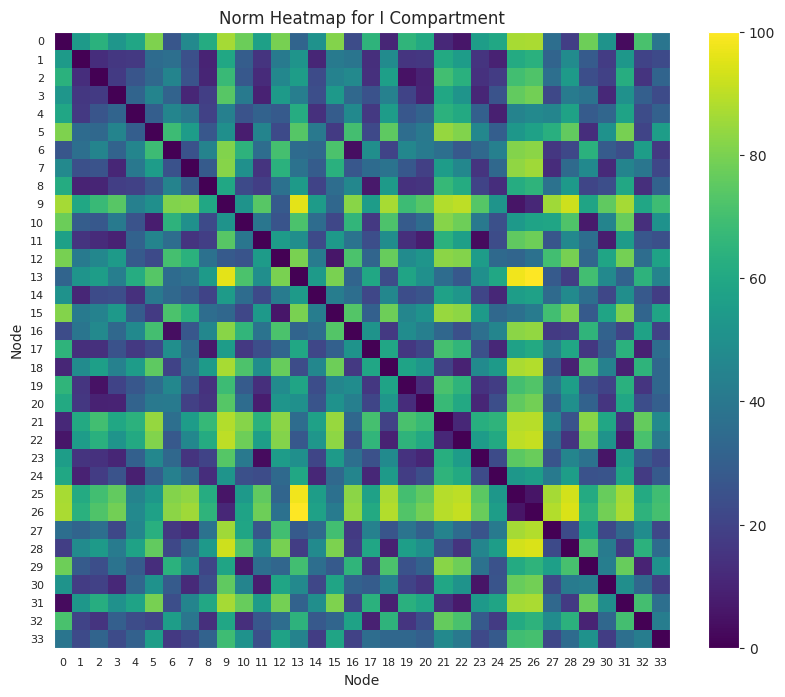

In [52]:
sir_flux_model.plot_heatmap_for_compartment(solution, 'I')

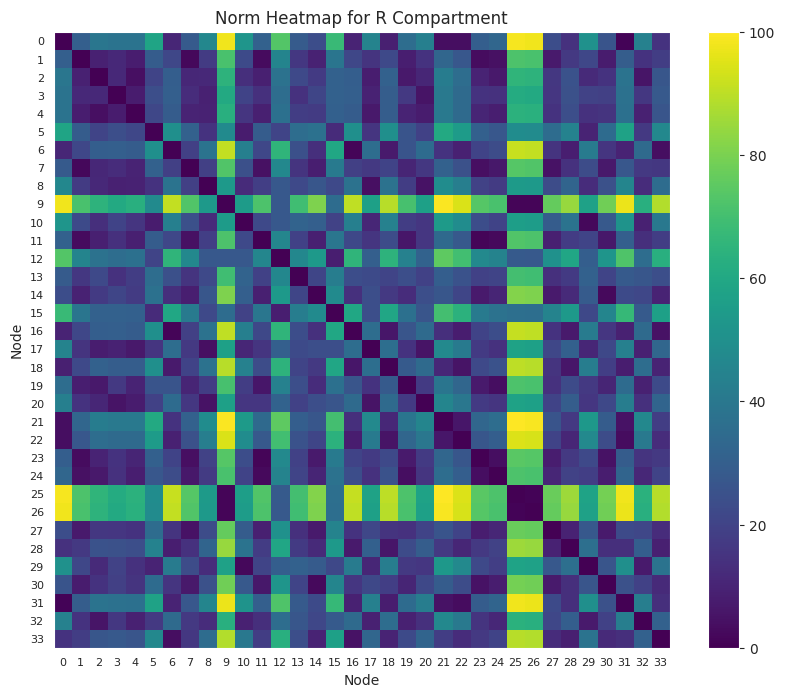

In [53]:
sir_flux_model.plot_heatmap_for_compartment(solution, 'R')